In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [55]:
from flask import Flask, jsonify

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [56]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [57]:
# Flask setup 
app = Flask(__name__)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement 
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Inspect measurement 

inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Most recent date in dataset
recent = session.query(measurement.date).order_by(measurement.date).first()
print(recent)

('2010-01-01',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
recent = session.query(measurement.date).order_by(measurement.date).first()

# Calculate the date one year from the last date in data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

prev_year = dt.date(2010, 1, 1) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for those 12 months 
prec_data = session.query(measurement.date, func.avg(measurement.prcp)).\
                    filter(measurement.date >= prev_year).\
                    group_by(measurement.date).all()
prec_data

[('2010-01-01', 0.15142857142857144),
 ('2010-01-02', 0.002857142857142857),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0014285714285714286),
 ('2010-01-05', 0.005),
 ('2010-01-06', 0.11600000000000002),
 ('2010-01-07', 0.27499999999999997),
 ('2010-01-08', 0.008571428571428572),
 ('2010-01-09', 0.002857142857142857),
 ('2010-01-10', 0.002857142857142857),
 ('2010-01-11', 0.12571428571428572),
 ('2010-01-12', 0.002857142857142857),
 ('2010-01-13', 0.0033333333333333335),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0),
 ('2010-01-16', 0.0),
 ('2010-01-17', 0.0),
 ('2010-01-18', 0.0),
 ('2010-01-19', 0.0),
 ('2010-01-20', 0.0014285714285714286),
 ('2010-01-21', 0.10833333333333334),
 ('2010-01-22', 0.0),
 ('2010-01-23', 0.0),
 ('2010-01-24', 0.0033333333333333335),
 ('2010-01-25', 0.0),
 ('2010-01-26', 0.03571428571428571),
 ('2010-01-27', 0.2285714285714286),
 ('2010-01-28', 0.12166666666666666),
 ('2010-01-29', 0.438),
 ('2010-01-30', 1.4700000000000002),
 ('2010-01-31', 0.36000000000000004),

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_data_df = pd.DataFrame(prec_data)
prec_data_df.head()

# Set index and change column names 
prec_data_df = prec_data_df.rename(columns={0:"Date"})
prec_data_df = prec_data_df.rename(columns={1:"Precipitation"})

prcp_df = prec_data_df.set_index("Date")

# Sort the dataframe by date
prcp_df.sort_values(by=['Date'])
prcp_df.head()

,Precipitation
Date,
2010-01-01,0.151429
2010-01-02,0.002857
2010-01-03,0.000000
2010-01-04,0.001429
2010-01-05,0.005000


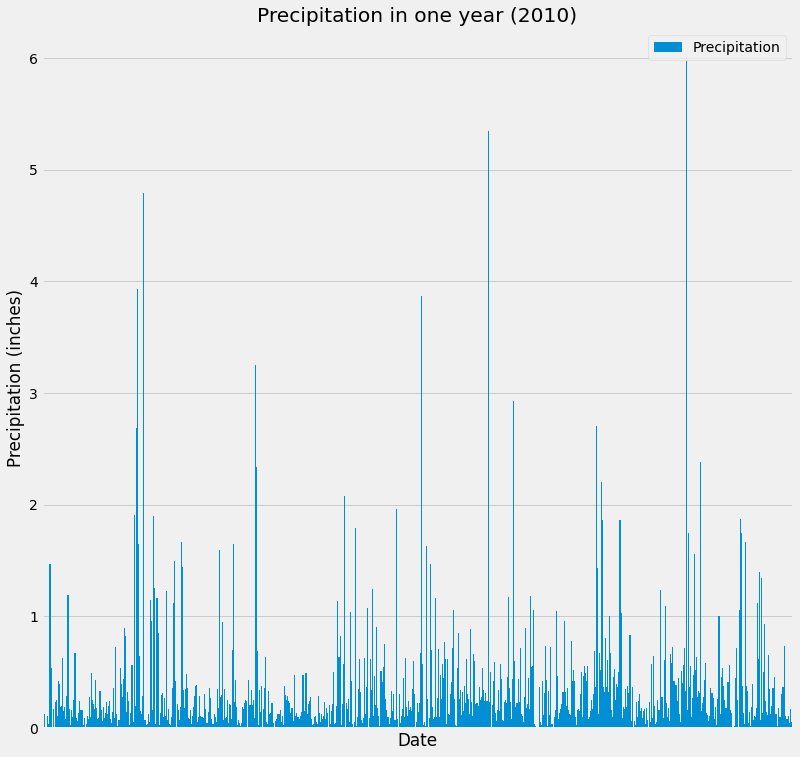

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_df.plot(kind ="bar", width=4, figsize=(12,12))

plt.title("Precipitation in one year (2010)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
ax.axes.xaxis.set_ticks([])
plt.legend(loc ="upper right")
plt.tight_layout
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2792.000000
mean,0.161962
std,0.345704
min,0.000000
25%,0.010000
50%,0.058333
75%,0.173571
max,5.970000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Count stations
count = session.query(station.id).count()
print(f"There are {count} stations in the dataset.")

There are 9 stations in the dataset.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  group_by(measurement.station).\
                  order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Use functions such as func.min, func.max, func.avg, and func.count
active_stations[0][0]

'USC00519281'

In [39]:
# Lowest, highest, and average temperature
active_station_temp = session.query(measurement.station, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
    filter(measurement.station == active_stations[0][0]).all()

active_station_temp

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter(measurement.date > prev_year)

active_station_df = pd.DataFrame(active_station_temp)
active_station_df = active_station_df.rename(columns={0:"Station"})
active_station_df = active_station_df.rename(columns={1:"Date"})
active_station_df = active_station_df.rename(columns={2:"Temp"})
active_station_df.head()

,Station,Date,Temp
0,USC00519281,2010-01-01,70.0
1,USC00519281,2010-01-02,62.0
2,USC00519281,2010-01-03,74.0
3,USC00519281,2010-01-04,75.0
4,USC00519281,2010-01-05,74.0


Text(0, 0.5, 'Frequency')

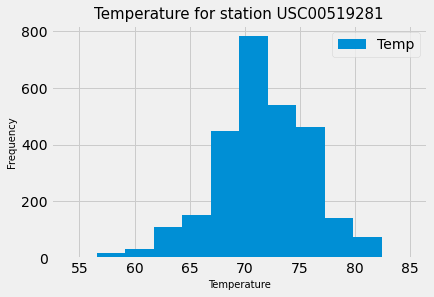

In [48]:
# Histogram - bins = 12
active_station_df.plot.hist(by="station", bins=12)
plt.title("Temperature for station " + active_stations[0][0], fontsize = 15)
plt.xlabel("Temperature", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)


## FLASK

In [64]:
all_station_temp = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.date > prev_year)

In [66]:
app = Flask(__name__)

@app.route("/")
def home():
    return("All available routes: precipitation, stations, tobs, start date, end date")

@app.route("/api/v1.0/precipitation")
def precipitation():
    return jsonify(prec_data)

@app.route("/api/v1.0/stations")
def stations():
    return jsonify(active_station_df[Station])

@app.route("/api/v1.0/tobs")
def tobs():
    return jsonify(all_station_temp)

@app.route("/api/v1.0/<start>")
def start(date):
    date_temp = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).filter(measurement.date >= date).all()
    return jsonify(date_temp)

@app.route("/api/v1.0/<start>/<end>")
def startend(date):
    start_end_date_temp = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).filter(measurement.date >= start).filter(measurement.date <= end).all()
    return jsonify(start_end_date_temp)

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

# Close session

In [49]:
# Close Session
session.close()